In [21]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.losses import Huber

In [23]:
# open HDF5 file

f1 = h5py.File("./cushion_twophase100x100x50v5.h5", 'r')
f2 = h5py.File("./cushion_twophase100x100x100v0.005.h5", 'r')
f3 = h5py.File("./cushion_twophase200x200x100v0.005.h5", 'r')
f4 = h5py.File("./cushion_twophase200x200x100v0.005.h5", 'r')
f5 = h5py.File("./cushion_twophase200x200x100v0.05.h5", 'r')
f6 = h5py.File("./cushion_twophase200x200x100v5.h5", 'r')
f7 = h5py.File("./cushion_twophase200x200x100v5000.h5", 'r')

f_all = [f1,f2,f3,f4,f5,f6,f7]

template_paths = [
    "Function/CS/{i}", "Function/FS/{i}", "Function/JS/{i}",
    "Function/KF/{i}", "Function/P_S/{i}", "Function/S_S/{i}", 
    "Function/T_S/{i}", "Function/eigS1_CS/{i}", "Function/eigS2_CS/{i}", 
    "Function/eigS3_CS/{i}", "Function/gradp/{i}", "Function/nS/{i}",
    "Function/p/{i}", "Function/rhoFR/{i}", "Function/uS/{i}",
    "Function/wFR/{i}", "Mesh/mesh/geometry", "Mesh/mesh/topology"]

In [25]:
with h5py.File(files[0], "r") as h5_file:
    def print_shapes(name, obj):
        # Check the object type; if it's a dataset, print its shape
        if isinstance(obj, h5py.Dataset):
            print(f"Path: {name}, Shape: {obj.shape}")

    # Recursively traverse all paths in the file
    h5_file.visititems(print_shapes)

Path: Function/CS/0_10000000000000001, Shape: (1183, 9)
Path: Function/CS/0_20000000000000001, Shape: (1183, 9)
Path: Function/CS/0_30000000000000004, Shape: (1183, 9)
Path: Function/CS/0_40000000000000002, Shape: (1183, 9)
Path: Function/CS/0_5, Shape: (1183, 9)
Path: Function/CS/0_59999999999999998, Shape: (1183, 9)
Path: Function/CS/0_69999999999999996, Shape: (1183, 9)
Path: Function/CS/0_79999999999999993, Shape: (1183, 9)
Path: Function/CS/0_89999999999999991, Shape: (1183, 9)
Path: Function/CS/0_99999999999999989, Shape: (1183, 9)
Path: Function/CS/1_0999999999999999, Shape: (1183, 9)
Path: Function/CS/1_2, Shape: (1183, 9)
Path: Function/CS/1_3, Shape: (1183, 9)
Path: Function/CS/1_4000000000000001, Shape: (1183, 9)
Path: Function/CS/1_5000000000000002, Shape: (1183, 9)
Path: Function/CS/1_6000000000000003, Shape: (1183, 9)
Path: Function/CS/1_7000000000000004, Shape: (1183, 9)
Path: Function/CS/1_8000000000000005, Shape: (1183, 9)
Path: Function/CS/1_9000000000000006, Shape: (

In [55]:
# Call all dunction
def call_all(f):
    path_all = []
    def collect_path(name, obj):
        #if not "topology" in name: #filter
        path_all.append(name)
    f.visititems(collect_path)
    return path_all

#all files
for index, f in enumerate(f_all):
    print(f"File {index+1}:")
    
    path_all = call_all(f)

    group_x = []
    group_y =[]
    
    for path in path_all:
        if path.count("/") < 2:
            continue

        if "topology" in path:
            continue

        matrix_all = f[path][()]

        if "uS" in path:
            group_x.append(matrix_all)  # Add to group_x
        else:
            group_y.append(matrix_all)  # Add to group_y
            
        print(f"path: f{index+1}[\"{path}\"], shape: {np.shape(matrix_all)}")
        print(np.array(matrix_all)[:1])


File 1:
path: f1["Function/CS/0_10000000000000001"], shape: (1183, 9)
[[ 1.00000000e+00  0.00000000e+00 -9.80116800e-11  0.00000000e+00
   1.00000000e+00 -9.80148792e-11 -9.80116800e-11 -9.80148792e-11
   1.00000000e+00]]
path: f1["Function/CS/0_20000000000000001"], shape: (1183, 9)
[[ 1.          0.         -0.01469482  0.          1.         -0.01469482
  -0.01469482 -0.01469482  0.91710684]]
path: f1["Function/CS/0_30000000000000004"], shape: (1183, 9)
[[ 1.          0.         -0.03029266  0.          1.         -0.03029266
  -0.03029266 -0.03029266  0.82712981]]
path: f1["Function/CS/0_40000000000000002"], shape: (1183, 9)
[[ 1.          0.         -0.04668002  0.          1.         -0.04668002
  -0.04668002 -0.04668002  0.73069713]]
path: f1["Function/CS/0_5"], shape: (1183, 9)
[[ 1.          0.         -0.0636408   0.          1.         -0.0636408
  -0.0636408  -0.0636408   0.62953698]]
path: f1["Function/CS/0_59999999999999998"], shape: (1183, 9)
[[ 1.          0.         -0.

In [31]:
import re  # Used to extract numbers from filenames

results = []
uS_results = []  # List to store data for "Function/uS/{i}"
group_results_x = []  # List to store input matrices for each file
group_results_y = []  # List to store output matrices for each file

t_base = np.ones(1183).reshape(1183, 1)
    
# Iterate through each element in data_list
for idx, f in enumerate(data_list):
    print(f"\nFile {idx + 1}/{len(data_list)}\n")
    results.clear()
    uS_results.clear()  # Clear uS_results each time a new `f` is processed

    # Get all keys in the file
    all_keys = list(f.keys())  # Retrieve all top-level keys in the file
    print(f"All keys in file {idx + 1}: {all_keys}\n")

    # Filter keys for "Function/uS/"
    uS_keys = [key for key in all_keys if key.startswith("Function/uS/")]
    print(f"Filtered 'Function/uS/' keys: {uS_keys}\n")

    for key in uS_keys:
        try:
            # Try to get the data
            if "Function/uS/" in key:
                uS_results.append(f[key][()])  # Store "Function/uS/" data separately
                #print(f"uS_results entry added from key {key}, Shape: {data.shape}")
            else:
                feature_data = f[key][()]
                feature_i = [feature_data]
                feature_i.append(t_base)  # Add `t_base` if needed
                results.append(np.hstack(feature_i))
                #print(f"Results entry added from key {key}, Shape: {stacked_feature.shape}")
        except KeyError:
            #print(f"Key {key} does not exist. Skipping.")
            continue  # Skip this key if it causes an error

    # Stack all results vertically
    group_result_x = np.vstack(results)

    # Broadcast the extracted three numbers and add them to the input matrix
    extra_features_broadcast = np.tile(extra_features_array, (group_result_x.shape[0], 1))  # Expand (1, 3) to (n_rows, 3)
    group_result_x_with_features = np.hstack([group_result_x, extra_features_broadcast])  # Add to the right side
    group_results_x.append(group_result_x_with_features)
    print(f"Inp_matrix shape with extra features: {group_result_x_with_features.shape}")

    # Stack "Function/uS/{i}" data vertically into a matrix
    if uS_results:
        uS_matrix = np.vstack(uS_results)
        group_results_y.append(uS_matrix)
        print(f"Dis_matrix shape: {uS_matrix.shape}")
         


File 1/7

All keys in file 1: ['Function', 'Mesh']

Filtered 'Function/uS/' keys: []



ValueError: need at least one array to concatenate

In [ ]:
# Combine results into matrices
if results:
    group_result_x = np.vstack(results)
    print(f"Input matrix shape: {group_result_x.shape}")

if uS_results:
    uS_matrix = np.vstack(uS_results)
    print(f"Output matrix shape: {uS_matrix.shape}")

# Stack the final x and y matrices
x = np.vstack(group_results_x)
print(f"final input matrix shape with extra features: {x.shape}")
y = np.vstack(group_results_y)
print(f"final output matrix shape: {y.shape}")

In [ ]:
scalerx = MinMaxScaler()
#Normalize the dataset dataset and store it in x
x = scalerx.fit_transform(dataset_x)

In [ ]:
#divide our test array
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.8,random_state=20)

In [ ]:
# initialize a object named model from Tensorflow Sequential model class.
model = Sequential()

# 使用 Input 层明确声明输入形状
model.add(Input(shape=(x_train.shape[1],)))  # 显式声明输入层

# 后续层直接添加
#model.add(Dense(16, activation='relu'))  # 隐藏层1
model.add(Dense(64, activation='relu'))  # 隐藏层2
model.add(Dense(16, activation='relu'))  # 隐藏层3

model.add(Dense(3))  # 输出层

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           4,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,379 (21.01 KB)

 Trainable params: 5,379 (21.01 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile the built model with optimizer, loss and metrics

adam = tf.keras.optimizers.Adam(learning_rate=2e-6)


#adam = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)... for mac users
model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])

In [9]:
history = model.fit(x_train,y_train,epochs=30,batch_size=64,validation_data=(x_test,y_test))

Epoch 1/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.2268 - mae: 0.3508 - mse: 0.2268 - val_loss: 0.0244 - val_mae: 0.1020 - val_mse: 0.0244
Epoch 2/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0242 - mae: 0.0984 - mse: 0.0242 - val_loss: 0.0243 - val_mae: 0.0965 - val_mse: 0.0243
Epoch 3/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0243 - mae: 0.0974 - mse: 0.0243 - val_loss: 0.0243 - val_mae: 0.0984 - val_mse: 0.0243
Epoch 4/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0245 - mae: 0.0979 - mse: 0.0245 - val_loss: 0.0243 - val_mae: 0.0979 - val_mse: 0.0243
Epoch 5/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0245 - mae: 0.0979 - mse: 0.0245 - val_loss: 0.0243 - val_mae: 0.0977 - val_mse: 0.0243
Epoch 6/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0249 - mae: 0.0984 - mse: 0.0249 - val_loss: 0.0243 - val_mae: 0.0986 - val_mse: 0.0243
Epoch 7/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0244 - mae: 0.0976 - mse: 0.0

In [10]:
hist = pd.DataFrame(history.history)
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse
0,0.167418,0.299163,0.167418,0.024404,0.102024,0.024404
1,0.024456,0.098086,0.024456,0.024301,0.096534,0.024301
2,0.024455,0.097677,0.024455,0.024287,0.098448,0.024287
3,0.024452,0.097671,0.024452,0.024298,0.097876,0.024298
4,0.024468,0.097721,0.024468,0.024281,0.097697,0.024281


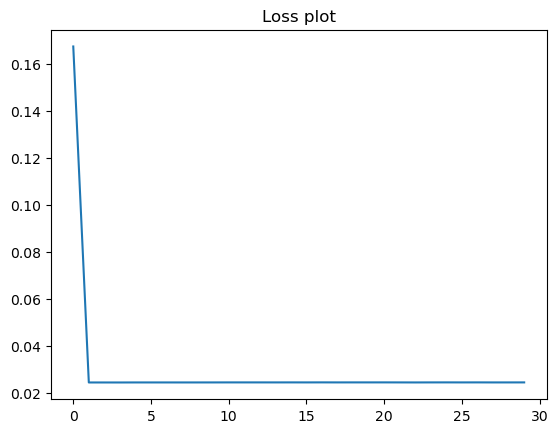

In [11]:
plt.title('Loss plot')
plt.plot(hist['loss'])

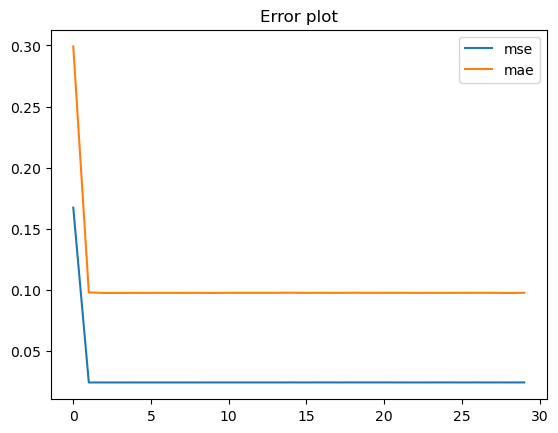

In [12]:
plt.title('Error plot')
plt.plot(hist['mse'], label='mse')
plt.plot(hist['mae'], label='mae')
plt.legend()